In [1]:
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
import pandas as pd
import re
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

from function_library import *
from function_library2 import *

DEBUG:matplotlib.backends:backend module://ipykernel.pylab.backend_inline version unknown


In [2]:
# if en_core_web_sm not install, run the following lines 
# !python -m spacy download en_core_web_sm

# Extract all email domains related with Edison

In [3]:
l_from = fromPickle('from_list')
l_to = fromPickle('to_list')
l_cc = fromPickle('cc_list')

In [4]:
df = pd.read_csv('new_clean_output.csv',index_col=0)
df['Sent'] = pd.to_datetime(df['Sent'])
body = df['Body'].values
subject = df['Subject'].values
edison = 'edison'
idx_list = []
for idx in range(len(body)):
    if edison in body[idx].lower() or edison in subject[idx].lower():
        idx_list.append(idx)

In [5]:
# find all the senders using the index list 
from_list = standardize_triplet(np.array(l_from)[idx_list].tolist())
name_list = set(from_list)

# find all the recipients using the index list 
to_list = standardize_triplet(np.array(l_to)[idx_list].tolist())
for names in to_list:
    name_list |= set(names)
cc_list = standardize_triplet(np.array(l_cc)[idx_list].tolist())
for names in cc_list:
    name_list |= set(names)

# convert to list and sort, in order to save to a txt
name_list = list(name_list)
name_list.sort()

domains = []
re_domain = re.compile(r'@(.*)')
for person in name_list:
    domains = domains + re_domain.findall(person[2])

domains = set(domains)
domains = list(domains)
toPickle(domains, 'l_domains')
len(domains)

75

In [6]:
fromPickle('l_domains')

['southernshakes.org',
 'unconventionalstrategies.com',
 'sandcofl.com',
 'wildwood-re.com',
 'markmustian.com',
 'tallahassee.com',
 'famu.edu',
 'staybridgetlh.com',
 'vicimarketing.com',
 'hotelduval.com',
 'hotmail.com',
 'baycrestcorp.com',
 'rrbsystems.com',
 'kccitallahassee.com',
 'rtdlawpa.com',
 'domiventures.co',
 'think3d.net',
 'v-int.com',
 'yahoo.com',
 'conedist.com',
 'wggdlaw.com',
 'leonpa.org',
 'theedmondgroup.comcastbiz.net',
 'comcast.net',
 'edisontally.com',
 'edisonrestaurant.com',
 'culpeppercc.com',
 'aol.com',
 'embarqmail.com',
 '101tally.com',
 'kevinhattaway.com',
 'hunterandharp.com',
 'gmail.com',
 'inkbridge.com',
 'ziffberry.com',
 'dos.myflorida.com',
 'blueprint2000.org',
 'knowlesandrandolph.com',
 'talcor.com',
 'realestateinsync.com',
 'music.org',
 'siebeinacoustic.com',
 'radeylaw.com',
 'rei-engineering.com',
 'leoncountyfl.gov',
 'preble-rish.com',
 'google.com',
 'genesisgroup.com',
 'fogellawgroup.com',
 'tmh.org',
 'talgov.com',
 'gtlaw.c

# Compare the POS distribution of different people in vector space

In [7]:
df2 = pd.read_csv('new_clean_output.csv',index_col = 0)

In [8]:
def find_all_related_email(person_email_addresses, find_list):
    person_emails_idx = []
    for idx,x in enumerate(find_list):
        for e in person_email_addresses:
            if e in x:
                person_emails_idx.append(idx)
                break
    return person_emails_idx

find_list = df2['From'].values

In [9]:
rick_email_addresses = ['McCraw, Rick','McCraw']
rick_emails_idx = find_all_related_email(rick_email_addresses, find_list)
len(rick_emails_idx)

372

In [10]:
ryan_email_addresses = ['Ryan Grindler','rgrindler','Grindler, Ryan']
ryan_emails_idx = find_all_related_email(ryan_email_addresses, find_list)
len(ryan_emails_idx)

510

In [11]:
mark_email_addresses = ['Beaudoin', 'mark.beaudoin@talgov.com', 'Mark.Beaudoin@talgov.com']
mark_emails_idx = find_all_related_email(mark_email_addresses, find_list)
len(mark_emails_idx)

437

In [12]:
adam_email_addresses = ['Adam B Corey','Adam Corey', 'Corey, Adam', 'acorey@101tally.com', 'acorey@gunster.com', 'adambcorey@gmail.com', 'adam@101tallahassee.com', 'adam@unconventionalstrategies.com']
adam_emails_idx = find_all_related_email(adam_email_addresses, find_list)
len(adam_emails_idx)

598

In [13]:
def normalize_pos_mat(mat_pos):
    m,n = mat_pos.shape
    mat_pos_normed = np.zeros_like(mat_pos)
    for i in range(m):
        if mat_pos[i,:].sum() != 0:
            mat_pos_normed[i,:] = mat_pos[i,:]/mat_pos[i,:].sum()
    return mat_pos_normed

In [14]:
df_pos = pd.read_csv('pos_counts.csv',index_col=0)

df_pos_adam = df_pos.iloc[adam_emails_idx]
mat_pos_adam = df_pos_adam.values
mat_pos_adam_normed = normalize_pos_mat(mat_pos_adam)
        
df_pos_mark = df_pos.iloc[mark_emails_idx]
mat_pos_mark = df_pos_mark.values
mat_pos_mark_normed = normalize_pos_mat(mat_pos_mark)

df_pos_ryan = df_pos.iloc[ryan_emails_idx]
mat_pos_ryan = df_pos_ryan.values
mat_pos_ryan_normed = normalize_pos_mat(mat_pos_ryan)

df_pos_rick = df_pos.iloc[rick_emails_idx]
mat_pos_rick = df_pos_rick.values
mat_pos_rick_normed = normalize_pos_mat(mat_pos_rick)

# PCA on all data
mat_pos_all = np.vstack((mat_pos_adam_normed, mat_pos_mark_normed, mat_pos_ryan_normed, mat_pos_rick_normed))
pca = PCA(n_components=3)
pca.fit(mat_pos_all)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

DEBUG:matplotlib.backends:backend nbAgg version unknown


<IPython.core.display.Javascript object>


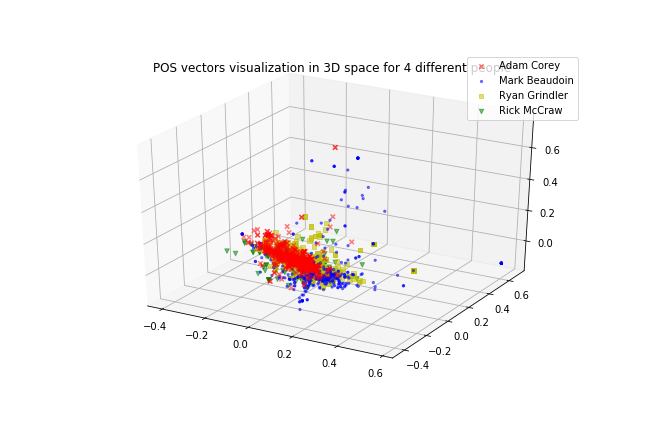

In [79]:
%matplotlib notebook
# %matplotlib inline

mats = [mat_pos_adam_normed, mat_pos_mark_normed, mat_pos_ryan_normed, mat_pos_rick_normed]
labels = [('r','x','Adam Corey'),('b','.','Mark Beaudoin'),('y','s', 'Ryan Grindler'),('g','v','Rick McCraw')]

fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
alpha = 0.5 

for idx, mat in enumerate(mats):
    pos_normed_pca = pca.transform(mat)
    x = pos_normed_pca[:,0]
    y = pos_normed_pca[:,1]
    z = pos_normed_pca[:,2]
    ax.scatter(x, y, z, c=labels[idx][0] ,marker = labels[idx][1], alpha = alpha, label = labels[idx][2])
    
plt.legend()
plt.title('POS vectors visualization in 3D space for 4 different people')
# plt.savefig('POS_3d.png')
plt.show()


In [72]:
# https://github.com/CircusMonkey/covariance-ellipsoid/blob/master/ellipsoid.py
def get_cov_ellipsoid(cov, mu=np.zeros((3)), nstd=3):
    assert cov.shape==(3,3)

    # Find and sort eigenvalues to correspond to the covariance matrix
    eigvals, eigvecs = np.linalg.eigh(cov)
    idx = np.sum(cov,axis=0).argsort()
    eigvals_temp = eigvals[idx]
    idx = eigvals_temp.argsort()
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:,idx]

    # Set of all spherical angles to draw our ellipsoid
    n_points = 100
    theta = np.linspace(0, 2*np.pi, n_points)
    phi = np.linspace(0, np.pi, n_points)

    # Width, height and depth of ellipsoid
    rx, ry, rz = nstd * np.sqrt(eigvals)

    # Get the xyz points for plotting
    # Cartesian coordinates that correspond to the spherical angles:
    X = rx * np.outer(np.cos(theta), np.sin(phi))
    Y = ry * np.outer(np.sin(theta), np.sin(phi))
    Z = rz * np.outer(np.ones_like(theta), np.cos(phi))

    # Rotate ellipsoid for off axis alignment
    old_shape = X.shape
    # Flatten to vectorise rotation
    X,Y,Z = X.flatten(), Y.flatten(), Z.flatten()
    X,Y,Z = np.matmul(eigvecs, np.array([X,Y,Z]))
    X,Y,Z = X.reshape(old_shape), Y.reshape(old_shape), Z.reshape(old_shape)
   
    # Add in offsets for the mean
    X = X + mu[0]
    Y = Y + mu[1]
    Z = Z + mu[2]
    
    return X,Y,Z

DEBUG:matplotlib.backends:backend nbAgg version unknown


<IPython.core.display.Javascript object>


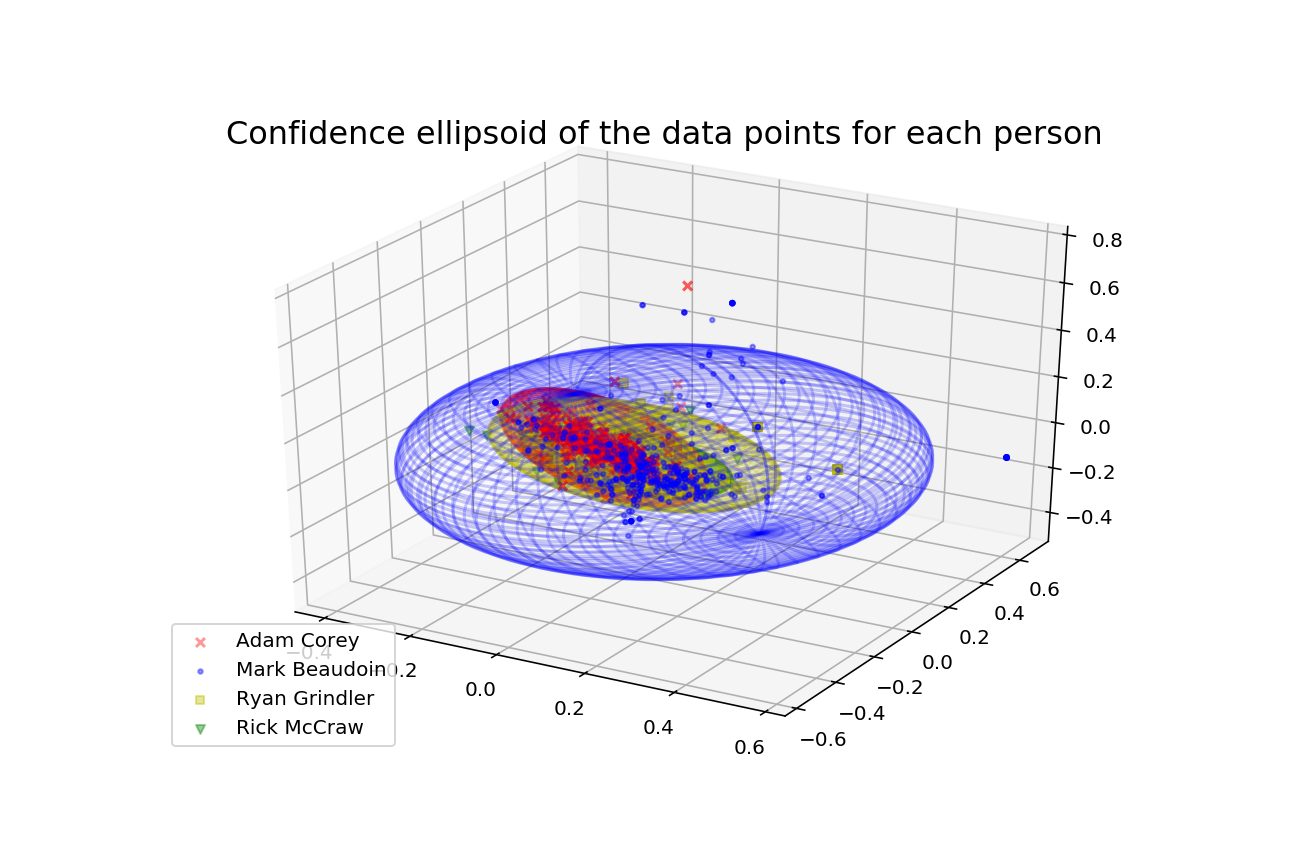

In [128]:
%matplotlib notebook
# %matplotlib inline

mats = [mat_pos_adam_normed, mat_pos_mark_normed, mat_pos_ryan_normed, mat_pos_rick_normed]
# mats = mats[1]

# labels contains the color, marker type, and label info
labels = [('r','x','Adam Corey'),('b','.','Mark Beaudoin'),('y','s', 'Ryan Grindler'),('g','v','Rick McCraw')]
# labels = labels[1]

fig = plt.figure(figsize=(9,6))  
ax = fig.add_subplot(111, projection='3d')

alpha1 = 0.4
alpha2 = 0.2

for idx, mat in enumerate(mats):
    pos_normed_pca = pca.transform(mat)
    
    x = pos_normed_pca[:,0]
    y = pos_normed_pca[:,1]
    z = pos_normed_pca[:,2]
    ax.scatter(x, y, z, c=labels[idx][0] ,marker = labels[idx][1], alpha = alpha1, label = labels[idx][2])
    
    cov = np.cov(pos_normed_pca.T)
    mu = np.mean(pos_normed_pca, axis = 0)
    X,Y,Z = get_cov_ellipsoid(cov,mu,3)
    ax.plot_wireframe(X,Y,Z, alpha = alpha2, color = labels[idx][0])
plt.title('Confidence ellipsoid of the data points for each person',fontsize =16)
ax.legend(loc = 3)
plt.show()


# Testing Named Entity Recognition

**The following outputs used the same paragraph from a news, but the outputs are slightly different.**  
**The first takes the whole paragragh as one input, while the second takes one sentence at a time.**

In [24]:
nlp = en_core_web_sm.load()

In [25]:
sentence = 'A winter storm will bring snow to portions of the Plains, Midwest and Northeast this week, likely disrupting travel and closing schools. A swath of heavy snowfall is likely across the Midwest into the lower to central Great Lakes on Tuesday and Wednesday, the National Weather Service said. Snowfall accumulations in these areas may range from 6 to 12 inches; some locally higher totals are possible. Several inches of snow is forecast to coat Chicago and Milwaukee, where significant travel impacts are possible starting Tuesday, the Weather Channel said.'

displacy.render(nlp(sentence), jupyter=True, style='ent')

In [26]:
sentence = 'A winter storm will bring snow to portions of the Plains, Midwest and Northeast this week, likely disrupting travel and closing schools. A swath of heavy snowfall is likely across the Midwest into the lower to central Great Lakes on Tuesday and Wednesday, the National Weather Service said. Snowfall accumulations in these areas may range from 6 to 12 inches; some locally higher totals are possible. Several inches of snow is forecast to coat Chicago and Milwaukee, where significant travel impacts are possible starting Tuesday, the Weather Channel said.'
sentences = sentence.split('.')
for sentence in sentences[:-1]:
    displacy.render(nlp(sentence), jupyter=True, style='ent')

# Explore some NER stats 

In [27]:
df = pd.read_csv('new_clean_output.csv', index_col=0)
# df.head()

In [28]:
re_rule = re.compile(r'\'(.*?)\'')

bodies_in_a_line = []
for body in df['Body'].values:
    lines = re_rule.findall(body)
    body_in_a_line = ''
    for line in lines:
        body_in_a_line = body_in_a_line + ' ' + line
    body_in_a_line = body_in_a_line.replace('  ',' ')
    body_in_a_line = body_in_a_line.replace('   ',' ')
    
    bodies_in_a_line.append(body_in_a_line.strip())

In [29]:
# this is slow, read from csv instead

# entities = []
# entity_counts = []
# for body in bodies_in_a_line:
#     entity_pair = []
#     doc = nlp(body)
#     entity_pair = [(x.text, x.label_) for x in doc.ents]
#     entities.append(entity_pair)
    
#     entity_count = [x.label_ for x in doc.ents]
#     entity_count = dict(Counter(entity_count))    
#     entity_counts.append(entity_count)

In [31]:
# df['entity'] = entities
# df['entity_counts'] = entity_counts
# df.to_csv('new_clean_output.csv')
# df.head()

In [32]:
# read entities back from csv

entities = df['entity'].values.tolist()
re_read_entities = re.compile(r'\(\'(.*?)\'\,\s\'(.*?)\'\)')

for i in range(len(entities)):
    entities[i] = re.findall(re_read_entities, entities[i])
df['entity'] = entities


In [33]:
# read entity_counts back from csv

entity_counts = df['entity_counts'].values.tolist()
re_read_entity_counts = re.compile(r'\'(.*?)\'\:\s([0-9]+)')

for i in range(len(entity_counts)):
    temp_dic = {}
    entity_counts[i] = re.findall(re_read_entity_counts, entity_counts[i])
    for j in range(len(entity_counts[i])):
        temp_dic[entity_counts[i][j][0]] = entity_counts[i][j][1]
    entity_counts[i] = temp_dic
df['entity_counts'] = entity_counts 


In [34]:
entity_counts = df['entity_counts'].values.tolist()
entity_names = []
for entity_count in entity_counts:
    entity_names = entity_names + list(entity_count.keys())
entity_names = list(set(entity_names))

In [35]:
mat_entity_counts = np.zeros((len(entity_counts), len(entity_names)))
for idx, entity_count in enumerate(entity_counts):
    for key in entity_count.keys():
        row_ind = idx
        col_ind = entity_names.index(key)
        mat_entity_counts[row_ind,col_ind] = entity_count[key]
        

DEBUG:matplotlib.backends:backend module://ipykernel.pylab.backend_inline version unknown


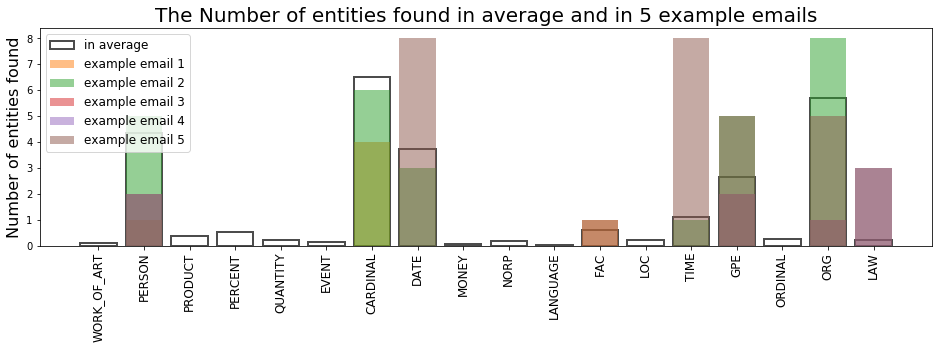

In [142]:
%matplotlib inline
entity_counts_mean = np.mean(mat_entity_counts,axis = 0)

plt.figure(figsize=(16,4))
plt.bar(np.arange(len(entity_names)),entity_counts_mean, alpha = 0.7, facecolor = 'none',edgecolor = 'black',linewidth=2, label = 'in average')
for i in range(5):
    plt.bar(np.arange(len(entity_names)), mat_entity_counts[i,:],alpha = 0.5, label='example email '+str(i+1))

plt.xticks(np.arange(len(entity_names)), entity_names,rotation = 90, fontsize = 12)
plt.ylabel('Number of entities found', fontsize = 16)
plt.title('The Number of entities found in average and in 5 example emails', fontsize = 20)
plt.legend(fontsize = 12)
plt.show()

In [93]:
person_entities = []
for entity in entities:
    for pair in entity:
        if pair[1] == 'PERSON':
            person_entities.append(pair[0])

In [103]:
person_entities_dict = dict(Counter(person_entities))

In [108]:
sorted_person_entities = []
sorted_person_entities_counts = []
sorted_person_entities_names = []

for k in sorted(person_entities_dict, key=person_entities_dict.get, reverse=True):
    sorted_person_entities.append((k, person_entities_dict[k]))
    sorted_person_entities_counts.append(person_entities_dict[k])
    sorted_person_entities_names.append(k)
print(sorted_person_entities[:10])

[('Adam Corey', 745), ('Ryan', 712), ('Rick', 615), ('Wayne', 507), ('Kim', 480), ('Paige Carter-Smith', 455), ('Kim Rivers', 427), ('Rick Rick McCraw', 378), ('Box', 368), ('Thompson', 368)]


DEBUG:matplotlib.backends:backend module://ipykernel.pylab.backend_inline version unknown


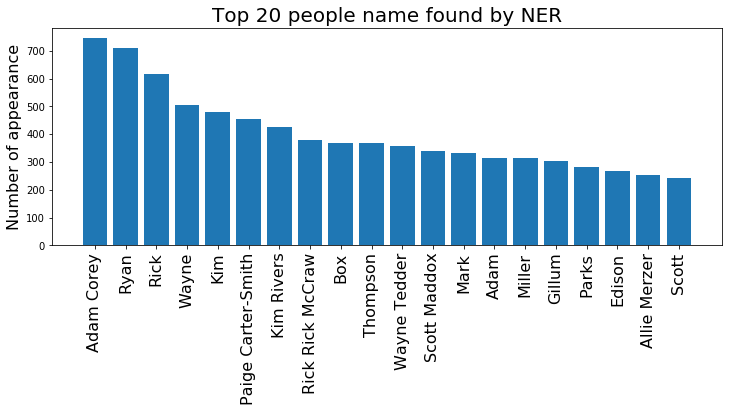

In [118]:
%matplotlib inline

nb_top = 20
plt.figure(figsize=(12,4))
plt.bar(np.arange(nb_top), sorted_person_entities_counts[:nb_top])
plt.xticks(np.arange(nb_top), sorted_person_entities_names[:nb_top],fontsize = 16,rotation = 90)
plt.title('Top '+str(nb_top)+' people name found by NER', fontsize = 20)
plt.ylabel('Number of appearance', fontsize = 16)
plt.show()